# Regression profiling
This notebook documents our adventures of trying to figure out how sensitive our regressions are to TPOT hyperparameters. This builds our intuition regarding how quickly we can build our models without too much sacrificing performance.

Execution time depends mainly on the hyperparameters used for TPOT. Execution time increases linearly with the number of generations and the population size, and increases both the generations and population size scale multiplicatively. It took about 8-12 hours to run this entire notebook.

# Initialize

In [1]:
# Set the path for the cache location
gaspy_path = '/global/project/projectdirs/m2755/GASpy/'
cache_path = gaspy_path + 'GASpy_regressions/cache/profiling/'

In [2]:
# Modify the path so that we use GASpy_dev instead of GASpy
#import sys
#gaspy_path = '/global/project/projectdirs/m2755/GASpy_dev/'
#sys.path.insert(0, gaspy_path)
#sys.path.insert(0, gaspy_path + '/GASpy_feedback')
#sys.path.insert(0, gaspy_path + '/GASpy_regressions')
#cache_path = gaspy_path + 'GASpy_regressions/cache/profiling/'

In [3]:
import dill as pickle
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from tpot import TPOTRegressor
from sklearn import metrics
from gaspy_regress.regressor import GASpyRegressor
from gaspy_regress.preprocessor import GASpyPreprocessor
from gaspy_regress import gio, plot, predict
from gaspy.utils import vasp_settings_to_str

In [4]:
init_notebook_mode(connected=True)
%matplotlib inline

VASP_SETTINGS = vasp_settings_to_str({'gga': 'RP',
                                      'pp_version': '5.4',
                                      'encut': 350})
features = ['coordatoms_chemfp0', 'neighbors_chemfp0']
responses = ['energy']
blocks = ['adsorbate']
block = ('CO',)

# Pre-work
We make some functions to condense the reading

In [5]:
model_name = 'profiling'

# We make a function that creates and fits a GASpyRegressor.
# We'll be using this over and over for profiling.
def create_model(gen, pop, dim_red=None, random_state=42, n_jobs=8, **pp_args):
    '''
    This function makes and fits a GASpyRegressor class using TPOT.
    
    Inputs:
        gen         [int] How many TPOT generations you want to use
        pop         [int] The TPOT population size you want to use
        dim_red     [str] A string indicating the type of
                    dimensionality reduction technique you want to use.
        **pp_args   Any arguments you want to pass to the dimensionality
                    reducer you're using.
    '''
    tpot = TPOTRegressor(generations=gen,
                         population_size=pop,
                         offspring_size=pop,
                         scoring='neg_median_absolute_error',
                         n_jobs=n_jobs,
                         verbosity=2, random_state=random_state)
    H = GASpyRegressor(features=features, responses=responses,
                       blocks=blocks, vasp_settings=VASP_SETTINGS,
                       train_size=0.8, dev_size=0.1,
                       dim_red=dim_red, **pp_args)
    H.fit_tpot(tpot, model_name=model_name, blocks=[block])
    return H

In [6]:
# Make a function to do the plotting
def plot_3d_profile(x, y, residuals, dataset='dev', metric='rmse'):
    '''
    This function is simply a wrapper for creating 3D scatter plot profiles
    
    Inputs:
        x          [np.array] A vector for the x-axis
        y          [np.array] A vector for the x-axis
        residuals  [list in a list] The residuals dictionaries that correspond to
                   the x and y settings. This assumes that these dictionaries
                   have the keys `block` and 'dev', where `block` is the model
                   block defined near the top of this notebook.
        dataset    [str] Indicates which dataset you want to plot. Can be
                   'train', 'dev', 'test', or 'all'.
        metric     [str] Indicates what metric you want to plot. Can be
                   'rmse' for root mean squared error; 'mae' for mean absolute
                   error, or 'mad' for median absolute deviation.
    '''

    # Format the data
    X, Y = np.meshgrid(x, y)
    Z = np.empty((len(y), len(x)))
    for i, _ in enumerate(x):
        for j, _ in enumerate(y):
            # Calculate whatever metric that we're looking for
            z_hat = residuals[i][j][block][dataset]
            z = np.zeros(z_hat.shape)
            if metric == 'rmse' or 'RMSE':
                Z[j, i] = np.sqrt(metrics.mean_squared_error(z, z_hat))
            elif metric == 'mae' or 'MAE':
                Z[j, i] = metrics.mean_absolute_error(z, z_hat)
            elif metric == 'mad' or 'MAD':
                Z[j, i] = metrics.median_absolute_deviation(z, z_hat)
            else:
                raise SyntaxError('%s is not a valid argument for "metric"')

    # Plot it
    trace = go.Scatter3d(x=X.flatten(), y=Y.flatten(), z=Z.flatten(), mode='markers')
    xaxis = dict(title='Generations', range=[x.min()-1, x.max()+1])
    yaxis = dict(title='Populations', range=[y.min()-1, y.max()+1])
    zaxis = dict(title=metric)
    layout = go.Layout(scene=dict(xaxis=xaxis, yaxis=yaxis, zaxis=zaxis))
    iplot(go.Figure(data=[trace], layout=layout))

# Without dim_red
We first did this without using any dimensionality reduction becaues... well, we forgot. Here are the results! It looks like the number of generations doesn't really matter. It also looks like the population size has some middle-point around 16 where it starts over-fitting.

In [7]:
# Set the space we want to investigate.
gens = np.linspace(1, 5, 3, dtype=int)
pops = np.linspace(1, 33, 5, dtype=int)

In [8]:
cache_path

'/global/project/projectdirs/m2755/GASpy_dev/GASpy_regressions/cache/profiling/'

In [9]:
# Open the results if they exist
try:
    with open(cache_path + 'profiling_nodimred.pkl', 'rb') as f:
        residuals = pickle.load(f)

# Create the results if they do not exist
except IOError:
    residuals = [[None]*len(pops)]*len(gens)
    for i, gen in enumerate(gens):
        for j, pop in enumerate(pops):
            residuals[i][j] = create_model(gen, pop).residuals
    # Save it
    with open(cache_path + 'profiling_nodimred.pkl', 'wb') as f:
        pickle.dump(residuals, f)

In [10]:
plot_3d_profile(gens, pops, residuals, dataset='dev', metric='rmse')

# With PCA
With PCA, it looks like we can halve the population size for similar performance. But decrease in performance at around 25 looks weird.

In [11]:
# Open the results if they exist
try:
    with open(cache_path + 'profiling_pca.pkl', 'rb') as f:
        residuals = pickle.load(f)

# Create the results if they do not exist
except IOError:
    # Execute the inner-loop regressions over a range.
    residuals = [[None]*len(pops)]*len(gens)
    for i, gen in enumerate(gens):
        for j, pop in enumerate(pops):
            model = create_model(gen, pop,
                                 dim_red='pca')
            residuals[i][j] = model.residuals
    # Save it
    with open(cache_path + 'profiling_pca.pkl', 'wb') as f:
        pickle.dump(residuals, f)

In [12]:
plot_3d_profile(gens, pops, residuals, dataset='dev', metric='rmse')

# Looking at population only
So the number of generations really doesn't seem to matter. If we drop that degree of freedom, then we can explore the population a bit better. Upon doing so, we find that population kind of sort of doesn't matter? There's an outlier at around 20. But the results of the previous profiling show that a population around 10 works well, too. We suspect that this might just be "random chance" that TPOT found a better model given a certain population size.

In [13]:
# Set the space we want to investigate.
gen = 1
pops = np.linspace(1, 100, 11, dtype=int)

In [14]:
# Open the results if they exist
try:
    with open(cache_path + 'profiling_population.pkl', 'rb') as f:
        residuals = pickle.load(f)

# Create the results if they do not exist
except IOError:
    # Execute the inner-loop regressions over a range.
    residuals = [None]*len(pops)
    for i, pop in enumerate(pops):
        model = create_model(gen, pop,
                             dim_red='pca')
        residuals[i] = model.residuals
    # Save it
    with open(cache_path + 'profiling_population.pkl', 'wb') as f:
        pickle.dump(residuals, f)

In [15]:
# Make a function to do the 2-D plotting
def plot_2d_profile(x, residuals, dataset='dev', metric='rmse'):
    '''
    This function is simply a wrapper for creating 3D scatter plot profiles
    
    Inputs:
        x          [np.array] A vector for the x-axis
        residuals  [list in a list] The residuals dictionaries that correspond to
                   the x and y settings. This assumes that these dictionaries
                   have the keys `block` and 'dev', where `block` is the model
                   block defined near the top of this notebook.
        dataset    [str] Indicates which dataset you want to plot. Can be
                   'train', 'dev', 'test', or 'all'.
        metric     [str] Indicates what metric you want to plot. Can be
                   'rmse' for root mean squared error; 'mae' for mean absolute
                   error, or 'mad' for median absolute deviation.
    '''

    # Format the data
    y = []
    for datum in residuals:
        resids = datum[block][dataset]
        baseline = np.zeros(resids.shape)
        if metric == 'rmse' or 'RMSE':
            y.append(np.sqrt(metrics.mean_squared_error(baseline, resids)))
        elif metric == 'mae' or 'MAE':
            y.append(metrics.mean_absolute_error(baseline, resids))
        elif metric == 'mad' or 'MAD':
            y.append(metrics.median_absolute_deviation(baseline, resids))
        else:
            raise SyntaxError('%s is not a valid argument for "metric"')
    y = np.array(y)

    # Plot it
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(x, y)
    ax = fig.axes[0]
    ax.set_xlabel('Population size')
    ax.set_ylabel(metric)
    plt.show()

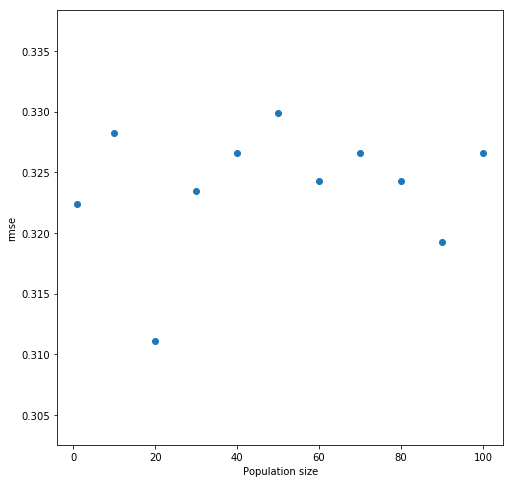

In [16]:
plot_2d_profile(pops, residuals, dataset='dev', metric='rmse')

# Looking at variance
To test the hypothesis that "random chance" plays the biggest factor in performance, we do a TPOT fitting over and over again and look at the distribution of residuals. It looks like there is some decent spread, but in general a population of 16 is probably sufficient.

In [17]:
# Open the results if they exist
try:
    with open(cache_path + 'profiling_variance.pkl', 'rb') as f:
        residuals = pickle.load(f)

# If they don't exist, then make and save them
except IOError:
    residuals = []
    for i in range(20):
        model = create_model(1, 16, dim_red='pca', n_jobs=16, random_state=None)
        residuals.append(model.residuals)
    with open(cache_path + 'profiling_variance.pkl', 'wb') as f:
        pickle.dump(residuals, f)

In [18]:
import seaborn as sns

# Make a function to make a histogram
def plot_histogram(residuals, dataset='dev', metric='rmse'):
    '''
    This function is simply a wrapper for creating 3D scatter plot profiles
    
    Inputs:
        residuals  [list in a list] The residuals dictionaries that correspond to
                   the x and y settings. This assumes that these dictionaries
                   have the keys `block` and 'dev', where `block` is the model
                   block defined near the top of this notebook.
        dataset    [str] Indicates which dataset you want to plot. Can be
                   'train', 'dev', 'test', or 'all'.
        metric     [str] Indicates what metric you want to plot. Can be
                   'rmse' for root mean squared error; 'mae' for mean absolute
                   error, or 'mad' for median absolute deviation.
    '''

    # Format the data
    y = []
    for datum in residuals:
        resids = datum[block][dataset]
        baseline = np.zeros(resids.shape)
        if metric == 'rmse' or 'RMSE':
            y.append(np.sqrt(metrics.mean_squared_error(baseline, resids)))
        elif metric == 'mae' or 'MAE':
            y.append(metrics.mean_absolute_error(baseline, resids))
        elif metric == 'mad' or 'MAD':
            y.append(metrics.median_absolute_deviation(baseline, resids))
        else:
            raise SyntaxError('%s is not a valid argument for "metric"')
    y = np.array(y)

    # Plot it
    fig = plt.figure(figsize=(8, 8))
    sns.distplot(y)
    ax = fig.axes[0]
    ax.set_xlabel(metric)
    plt.show()

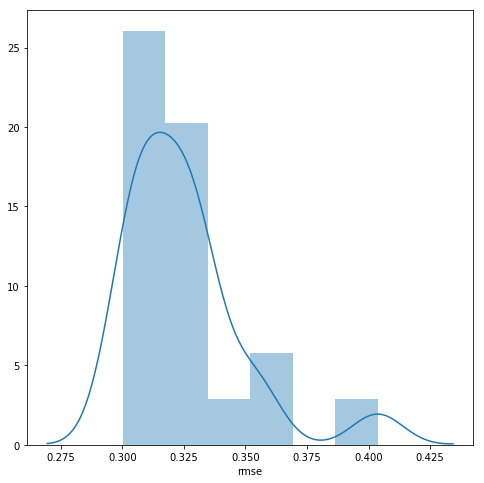

In [19]:
plot_histogram(residuals)